In [243]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import gurobipy as gp
from gurobipy import GRB

In [244]:
# function to fetch data from yahoo finance for 1 year
def FetchData(Tickers,Period="1y",Interval='1d',Start=None,End=None,Group_by='column',Column='Adj Close'):

    """
    Return the data for tickers
    Parameters:
        tickers : str, list             List of tickers to download
        period : str             Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max Either Use period parameter or use start and end
        interval : str             Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo Intraday data cannot extend last 60 days
        start: str             Download start date string (YYYY-MM-DD) or _datetime. Default is 1900-01-01
        end: str             Download end date string (YYYY-MM-DD) or _datetime. Default is now
        group_by : str             Group by 'ticker' or 'column' (default)
    """
    StockData = yf.download(Tickers,start=Start,end=End,period=Period,interval=Interval)

    if Column!=None:
        SelectedData = StockData[Column]
    else:
        SelectedData = StockData

    return(SelectedData)



In [245]:
def Calculation(Data_Selected):
    ''' calculate the mean percent change and covariance for the stocks. Then annualized the value and return. '''
   
    Stock_pct_change = Data_Selected.pct_change()
    Mean_Change = Stock_pct_change.mean()*252
    Change_Cov = Stock_pct_change.cov()*252
    
    return(Mean_Change,Change_Cov)

In [246]:
def ComparitiveDisplay(StockData):
    # Display the growth of stocks by setting starting price to 100
    # The graph is displayed then
    ticker_list=StockData.columns
    temp_df = pd.DataFrame()
    for i in ticker_list:
        temp_df[i]=(StockData[i]/StockData[i][0])*100
    
        
    plt.figure(figsize=(20,5))
    sns.lineplot(data=temp_df)

    return()
    

In [247]:
# Selection of the Stocks for optimization
Tickers_List = ['GE','T','PG','AMZN','CL','CVS']
StockPrice = FetchData(Tickers_List)
Stock_Mean_Change, Stock_Cov_Change = Calculation(StockPrice)

[*********************100%***********************]  6 of 6 completed


()

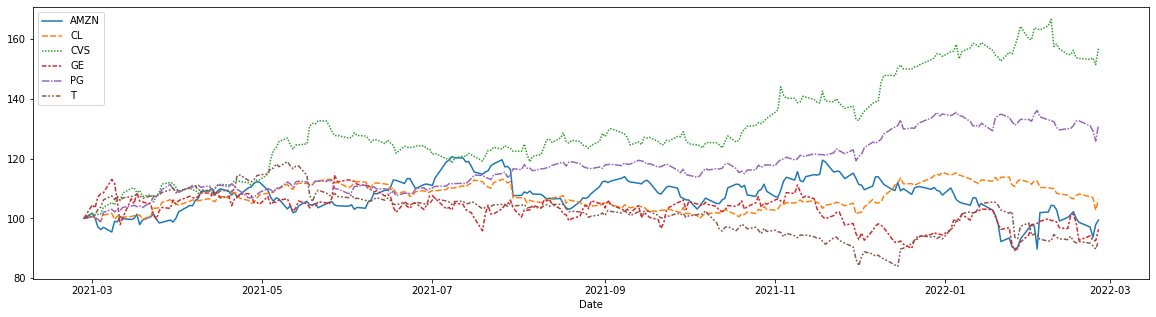

In [248]:
ComparitiveDisplay(StockPrice)

In [249]:
def Performance(weights, mean_change, change_cov):
    
    portfolio_return = np.dot(weights, mean_change)
    porfolio_std = np.dot(np.dot(change_cov, weights),weights)
    return(portfolio_return,porfolio_std)

In [250]:
Portfolio_Weights = np.ones(6)/6
Performance(Portfolio_Weights, Stock_Mean_Change, Stock_Cov_Change)

(0.1379557934882213, 0.01600698265879317)

In [251]:
def Efficient_Frontier_Montcarlo(Tickers,no_of_iter):
    stockdata = FetchData(Tickers)
    stock_mean_change, stock_cov_change = Calculation(stockdata)
    temp_data = pd.DataFrame(columns=['Return','Std_dev'])
    for i in range(no_of_iter):
        weights=np.random.random(6)
        portfolio_weights = weights/weights.sum()
        port_ret, port_std = Performance(portfolio_weights,stock_mean_change,stock_cov_change)
        temp1=pd.DataFrame([[port_ret,port_std]],columns=['Return','Std_dev'])
        temp_data = pd.concat([temp_data,temp1],ignore_index=True)
    plt.figure(figsize=(20,5))
    sns.scatterplot(data=temp_data,y='Return',x='Std_dev')
    return()

[*********************100%***********************]  6 of 6 completed


()

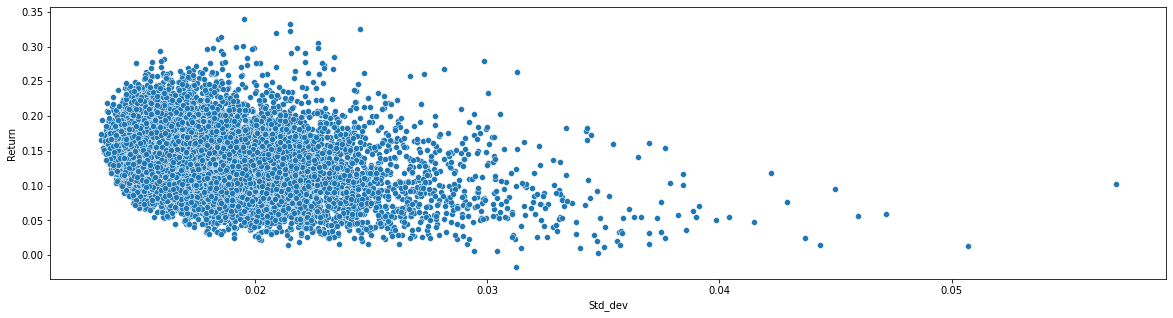

In [252]:
Efficient_Frontier_Montcarlo(Tickers_List,10000)

In [253]:
def SharpeRatio(Tickers,weights,RiskFreeRate):
    stockdata = FetchData(Tickers)
    stock_mean_change, stock_cov_change = Calculation(stockdata)
    port_ret, port_std = Performance(weights,stock_mean_change,stock_cov_change)

    return((port_ret-RiskFreeRate)/port_std)
    


In [254]:
SharpeRatio(Tickers_List, Portfolio_Weights, 0.025)

[*********************100%***********************]  6 of 6 completed


7.05665721276854

In [255]:
def OptimizedPortfolio(Tickers, Expectedreturn):

    stock_data = FetchData(Tickers)
    stock_mean_ret, stock_covariance = Calculation(stock_data)

    

    m = gp.Model('PortFolio optimization')

    weight = m.addMVar(len(Tickers))

    m.addConstr(weight.sum() == 1)
    port_std = weight @ stock_covariance.values @ weight
    port_ret = weight @ stock_mean_ret.values
    m.addConstr(port_ret == Expectedreturn)
    #m.addConstr(port_ret <= weight @ stock_mean_ret.values)

    
    m.setObjective(port_std, GRB.MINIMIZE)

    m.update()
    m.optimize()
    print(port_ret.getValue()[0])

    
    return(m.X)


In [256]:
Tickers_List = ['BRK-A', 'AAPL', 'MSFT', 'JPM', 'GOOG', 'BAC', 'INTC', 'WFC',
          'C', 'VZ', 'FB', 'PFE', 'JNJ', 'WMT', 'XOM',
          'FNMA', 'T', 'UNH', 'CMCSA', 'V' ]

In [270]:
def Efficient_Frontier_QP(Tickers,Resolution=4):

    stock_data = FetchData(Tickers)
    stock_mean_ret, stock_covariance = Calculation(stock_data)
    MinRet = 0#stock_mean_ret.values.min()
    MaxRet = 0.41#stock_mean_ret.values.max()
    m = gp.Model('PortFolio optimization')
    weight = m.addMVar(len(Tickers))
    m.addConstr(weight.sum() == 1)
    port_std = weight @ stock_covariance.values @ weight
    port_ret = weight @ stock_mean_ret.values
    returnrate = MinRet
    target = m.addConstr(port_ret == returnrate,'target')
    Frontier = pd.DataFrame([],columns=['Return','Std','Result'])
    for i in np.linspace(MinRet,MaxRet,Resolution):
        
        target[0].rhs = i
        #m.addConstr(port_ret <= weight @ stock_mean_ret.values)
        m.setObjective(port_std, GRB.MINIMIZE)
        m.update()
        m.optimize()
        temp = pd.DataFrame([[i,m.ObjVal,m.X]],columns=['Return','Std','Result'])

        Frontier = pd.concat([Frontier,temp],ignore_index=True)
    
    return(Frontier)

In [271]:
a=Efficient_Frontier_QP(Tickers_List,100)

[*********************100%***********************]  20 of 20 completed
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0xdc079c9d
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.59311163e+05 -1.59311163e+05  1.27e+04 6.33e-

[(0.0, 0.4)]

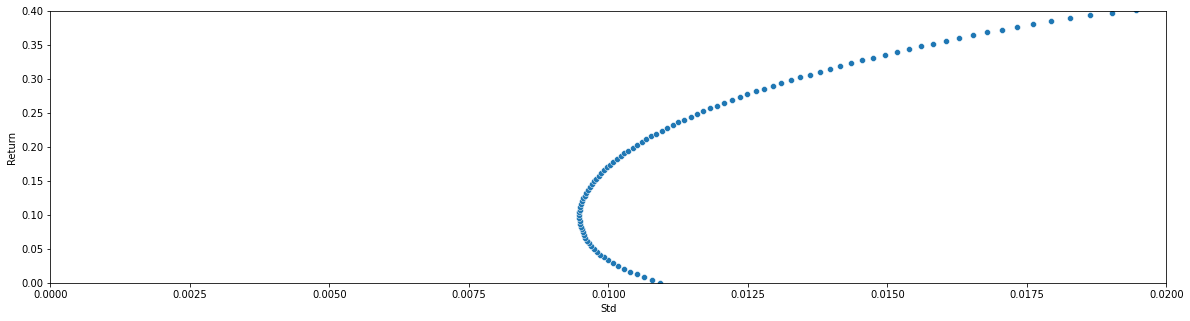

In [288]:
plt.figure(figsize=(20,5))

a_plot =sns.scatterplot(data=a,x='Std',y='Return')
a_plot. set(xlim=(0, 0.02))
a_plot. set(ylim=(0, 0.4))

In [284]:
RiskFreeInv = [0,0.025]
temp=0
for i in range(len(a)):
    Port_ret = a.loc[i,'Return']
    Std_ret = a.loc[i,'Std']
    slope = (Port_ret - 0.025)/(Std_ret - 0)
    if slope> temp:
        temp=max(temp,slope)
        b=a.loc[i,:]

print(b)


Return                                             0.327172
Std                                                0.014544
Result    [0.03794460818647452, 1.3046746661646316e-10, ...
Name: 79, dtype: object


In [ ]:
def DisplayEffFrontier(Tickers,Resolution):
    Efficient_Frontier_QP(Tickers,Resolution)